In [72]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
from scipy.stats import multivariate_normal

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
# read in dataset csv files
bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

In [34]:
# display first few rows of dataframe
bike_day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [35]:
day_mean = bike_day_df.mean()
day_var = bike_day_df.var()
print("Means:")
print(day_mean)
print("Vars:")
print(day_var)

Means:
instant        366.000000
season           2.496580
yr               0.500684
mnth             6.519836
holiday          0.028728
weekday          2.997264
workingday       0.683995
weathersit       1.395349
temp             0.495385
atemp            0.474354
hum              0.627894
windspeed        0.190486
casual         848.176471
registered    3656.172367
cnt           4504.348837
dtype: float64
Vars:
instant       4.459100e+04
season        1.233892e+00
yr            2.503420e-01
mnth          1.191570e+01
holiday       2.794071e-02
weekday       4.019171e+00
workingday    2.164421e-01
weathersit    2.969098e-01
temp          3.350767e-02
atemp         2.655635e-02
hum           2.028605e-02
windspeed     6.005920e-03
casual        4.714504e+05
registered    2.434400e+06
cnt           3.752788e+06
dtype: float64


/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/4108597628.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  day_mean = bike_day_df.mean()
/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/4108597628.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  day_var = bike_day_df.var()


In [36]:
# identify potential outliers in day df using IQR

Q1 = bike_day_df.quantile(0.25)
Q3 = bike_day_df.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((bike_day_df < lower_bound) | (bike_day_df > upper_bound))

outlier_counts = outliers.sum()

# Display the counts of outliers for each feature where they exist
outlier_counts[outlier_counts > 0]

/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/286650291.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = bike_day_df.quantile(0.25)
/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/286650291.py:4: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = bike_day_df.quantile(0.75)
/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/286650291.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((bike_day_df < 

casual       44
holiday      21
hum           2
windspeed    13
dtype: int64

In [37]:
# need for normalisation:
print("need to normalise, due to differences in scales, e.g., temp and windspeed are measured on different scales")
print("there are also high variations in variance values")
print("the presence of outliers must also be taken into consideration, as normalisation will reduce the impact of such extreme values")

need to normalise, due to differences in scales, e.g., temp and windspeed are measured on different scales
there are also high variations in variance values
the presence of outliers must also be taken into consideration, as normalisation will reduce the impact of such extreme values


In [38]:
# covariance matrix for day df
cov_matrix_day = bike_day_df.cov()

cov_matrix_day


/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/3372644851.py:2: FutureWarning: The default value of numeric_only in DataFrame.cov is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov_matrix_day = bike_day_df.cov()


,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,44591.000000,96.693151,91.500000,362.058904,0.569863,-0.006849,-0.426027,-2.471233,5.820548,5.252561,0.492488,-1.843008,39909.582192,2.173278e+05,2.572374e+05
season,96.693151,1.233892,-0.001025,3.188082,-0.001956,-0.006859,0.006452,0.011628,0.067978,0.062067,0.032504,-0.019717,160.472522,7.134020e+02,8.738745e+02
yr,91.500000,-0.001025,0.250342,-0.003096,0.000665,-0.005478,-0.000468,-0.013284,0.004360,0.003759,-0.007885,-0.000458,85.386865,4.639067e+02,5.492936e+02
mnth,362.058904,3.188082,-0.003096,11.915702,0.011073,0.065808,-0.009477,0.081873,0.139142,0.127952,0.109247,-0.055510,291.543755,1.580687e+03,1.872231e+03
holiday,0.569863,-0.001956,0.000665,0.011073,0.027941,-0.034168,-0.019677,-0.003154,-0.000874,-0.000885,-0.000379,0.000082,6.229170,-2.836112e+01,-2.213195e+01
weekday,-0.006849,-0.006859,-0.005478,0.065808,-0.034168,4.019171,0.033381,0.033960,-0.000062,-0.002462,-0.014914,0.002219,82.485415,1.794443e+02,2.619297e+02
workingday,-0.426027,0.006452,-0.000468,-0.009477,-0.019677,0.033381,0.216442,0.015514,0.004485,0.003956,0.001612,-0.000678,-165.483884,2.206011e+02,5.511723e+01
weathersit,-2.471233,0.011628,-0.013284,0.081873,-0.003154,0.033960,0.015514,0.296910,-0.012029,-0.010796,0.045870,0.001668,-92.543836,-2.213751e+02,-3.139189e+02
temp,5.820548,0.067978,0.004360,0.139142,-0.000874,-0.000062,0.004485,-0.012029,0.033508,0.029583,0.003310,-0.002241,68.283781,1.542309e+02,2.225147e+02
atemp,5.252561,0.062067,0.003759,0.127952,-0.000885,-0.002462,0.003956,-0.010796,0.029583,0.026556,0.003249,-0.002319,60.854436,1.383669e+02,1.992213e+02


In [39]:
# highly correlated variables in bike_day_df

# correlation matrix
correlation_matrix = bike_day_df.corr()

# pairs with high correlation (above 0.7 or below -0.7)
highly_correlated_pairs = correlation_matrix.unstack().sort_values(kind="quicksort", ascending=False)
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs.between(-1, -0.7, inclusive=False) | highly_correlated_pairs.between(0.7, 1, inclusive=False)]

# Remove duplicates
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs.index.get_level_values(0) < highly_correlated_pairs.index.get_level_values(1)]

# show correlated pairs
highly_correlated_pairs

/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/2315385460.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bike_day_df.corr()
/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/2315385460.py:8: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs.between(-1, -0.7, inclusive=False) | highly_correlated_pairs.between(0.7, 1, inclusive=False)]


atemp    temp          0.991702
cnt      registered    0.945517
instant  yr            0.866025
mnth     season        0.831440
dtype: float64

/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/437809555.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bike_day_df.corr()


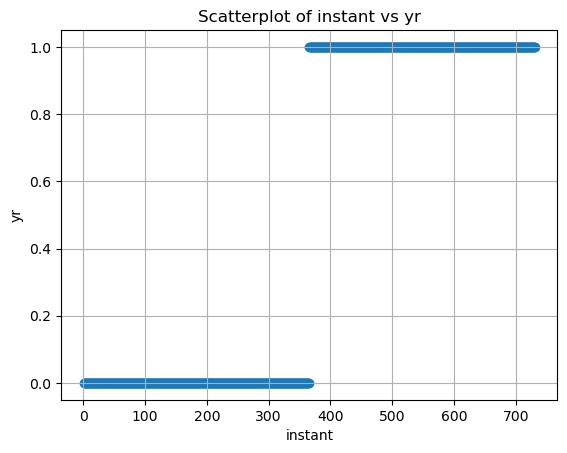

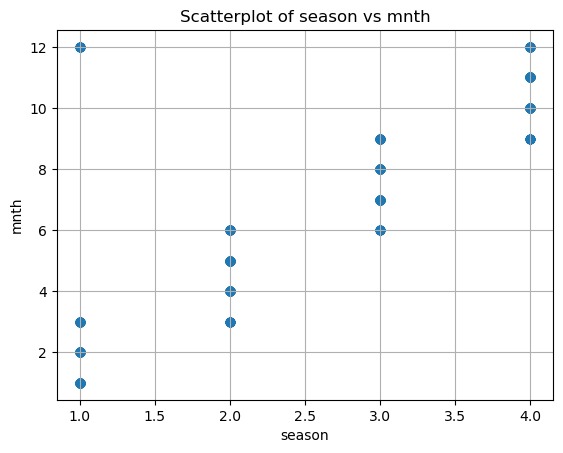

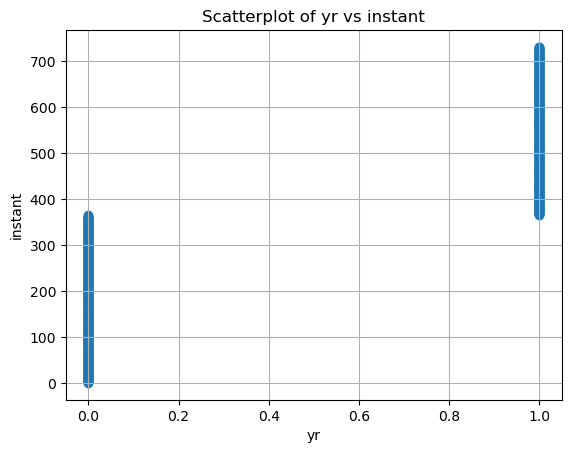

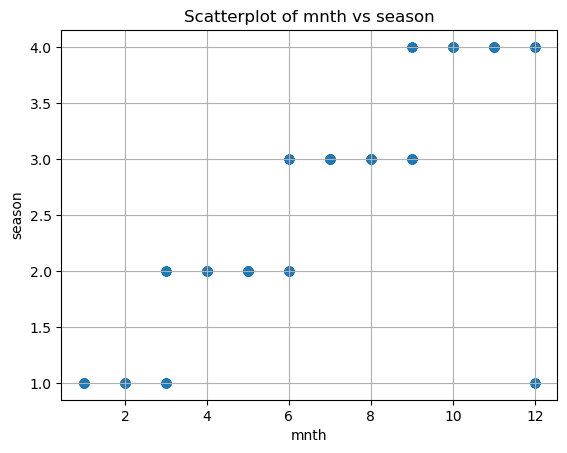

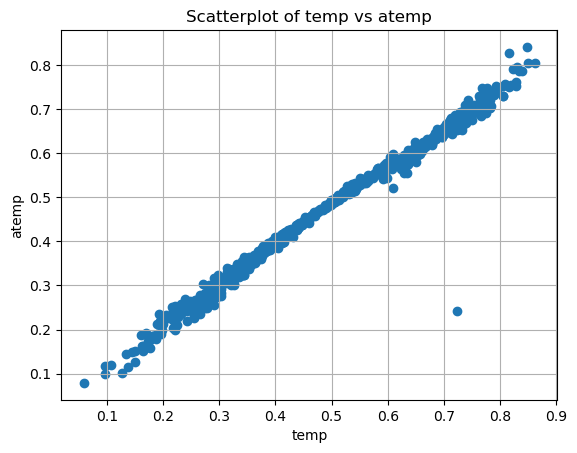

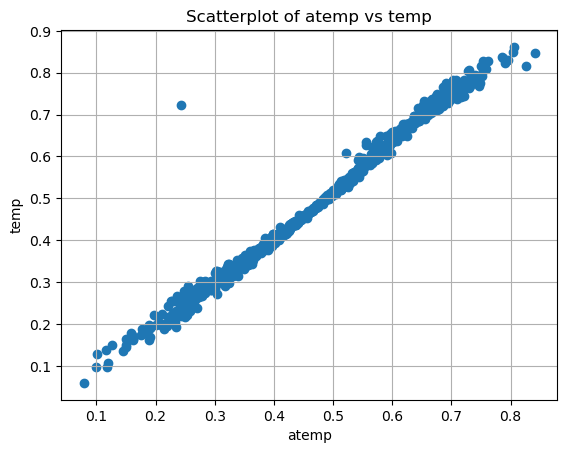

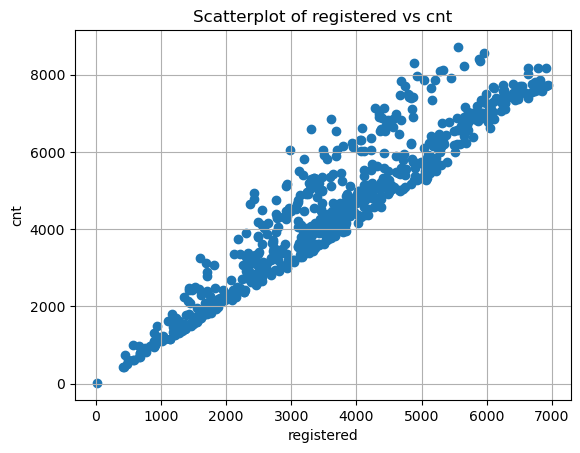

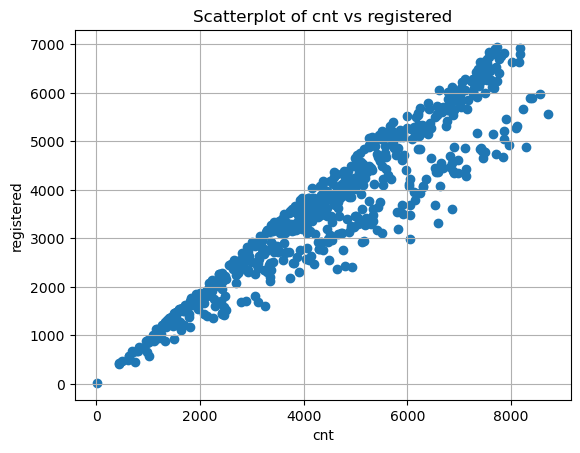

In [40]:
# scatter plots for highly correlated variables in bike_day_df

# identify highly correlated features
correlation_matrix = bike_day_df.corr()
threshold = 0.7  

# Create an empty list to store selected highly correlated features
selected_features = []

# Iterate through the correlation matrix to identify highly correlated features
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2 and correlation_matrix[feature1][feature2] > threshold:
            selected_features.append((feature1, feature2))

# Step 3: Generate scatterplots for the selected highly correlated features
for feature1, feature2 in selected_features:
    plt.scatter(bike_day_df[feature1], bike_day_df[feature2])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f"Scatterplot of {feature1} vs {feature2}")
    plt.grid(True)
    plt.show()

/var/folders/nk/bl1k3lvs58z0ppttvqfc_xdr0000gn/T/ipykernel_57123/2931994682.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = bike_day_df.corr()


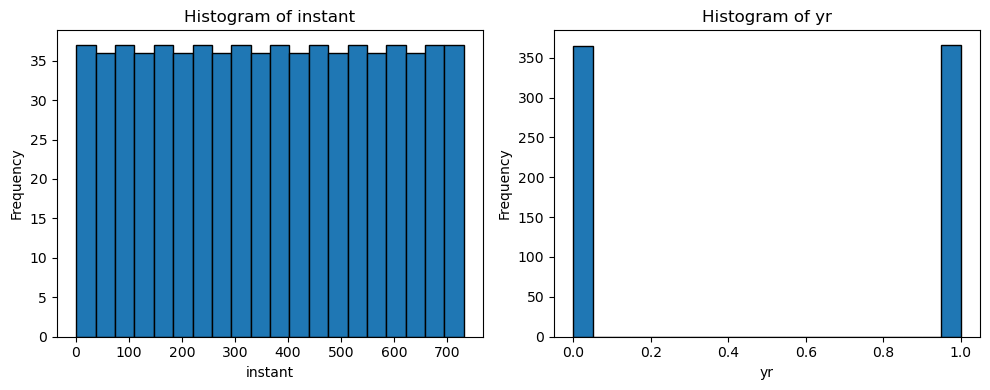

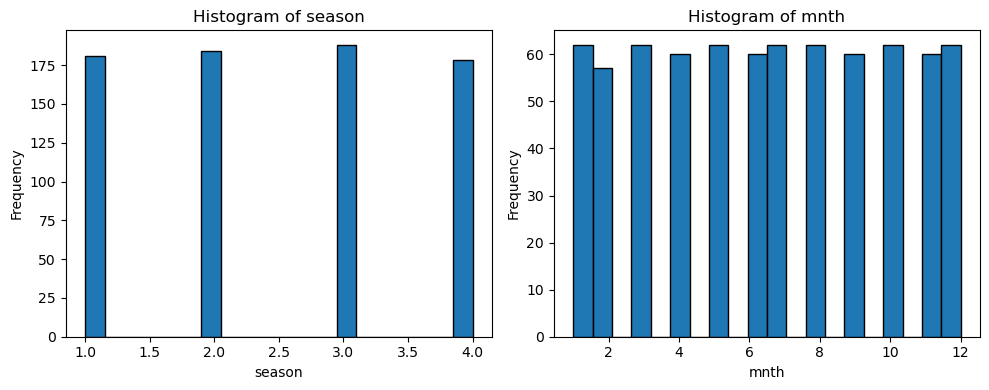

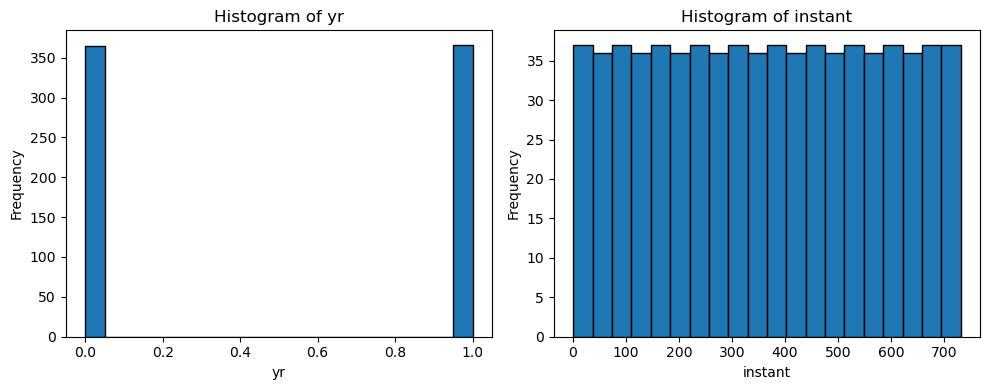

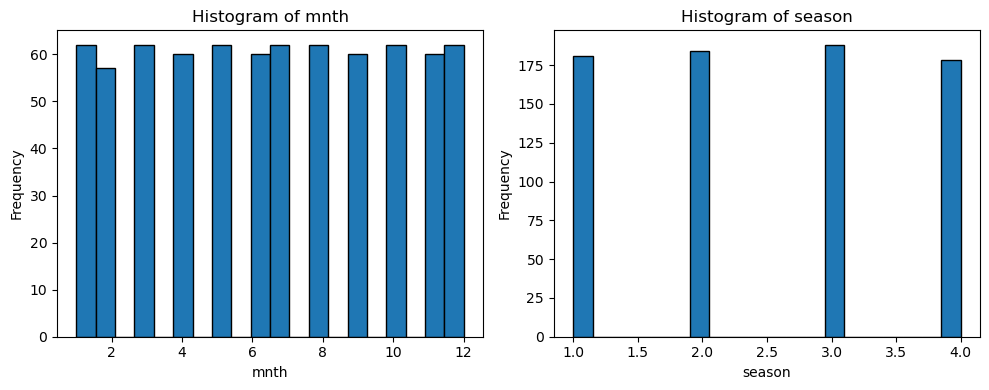

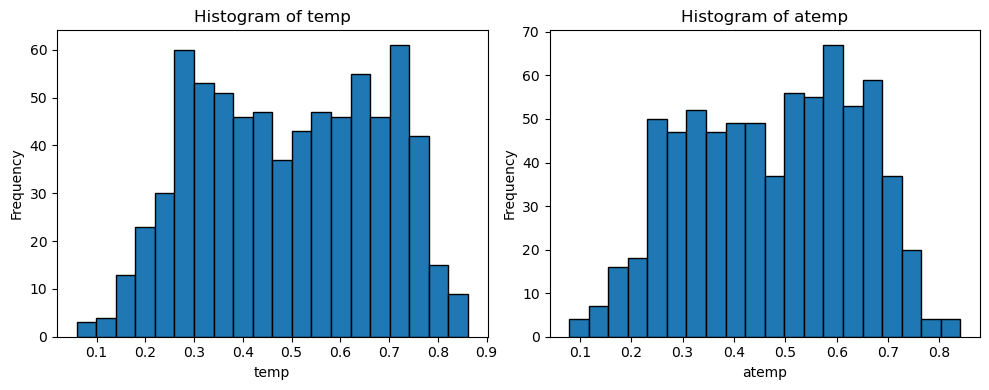

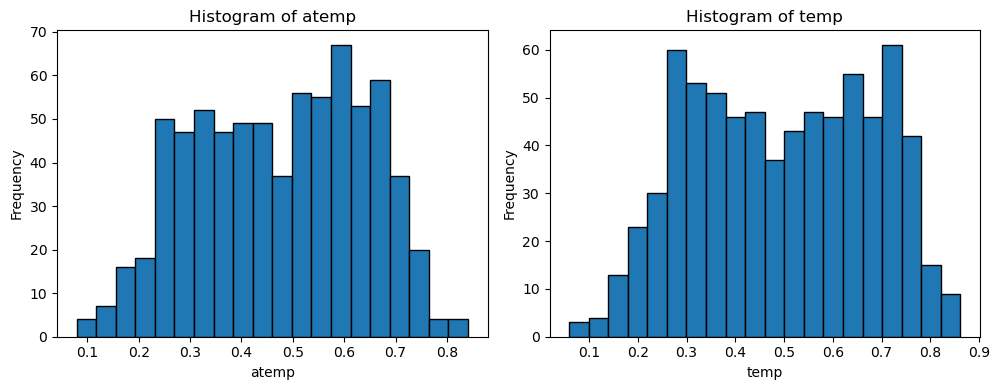

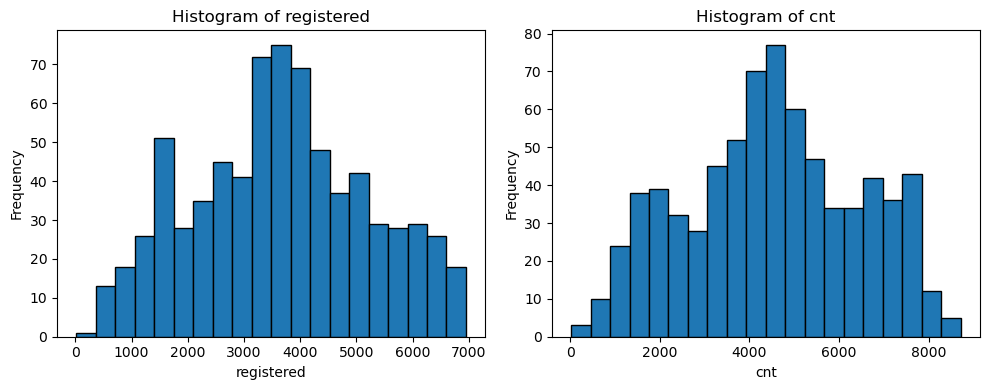

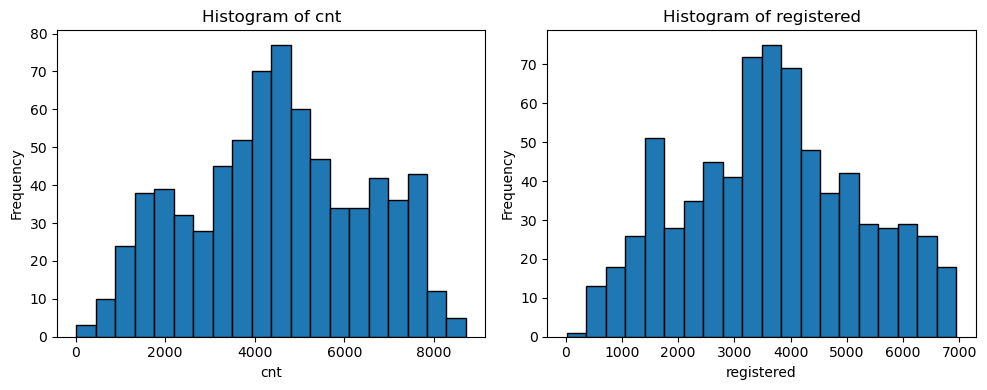

In [41]:
# histograms for bike_day_df

# identify highly correlated features 
correlation_matrix = bike_day_df.corr()
threshold = 0.7  # Adjust the correlation threshold as needed

# Create an empty list to store selected highly correlated features
selected_features = []

# Iterate through the correlation matrix to identify highly correlated features
for feature1 in correlation_matrix.columns:
    for feature2 in correlation_matrix.columns:
        if feature1 != feature2 and correlation_matrix[feature1][feature2] > threshold:
            selected_features.append((feature1, feature2))

# Step 3: Generate histograms for the selected highly correlated features
for feature1, feature2 in selected_features:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.hist(bike_day_df[feature1], bins=20, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature1}")

    plt.subplot(1, 2, 2)
    plt.hist(bike_day_df[feature2], bins=20, edgecolor='k')
    plt.xlabel(feature2)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {feature2}")

    plt.tight_layout()
    plt.show()

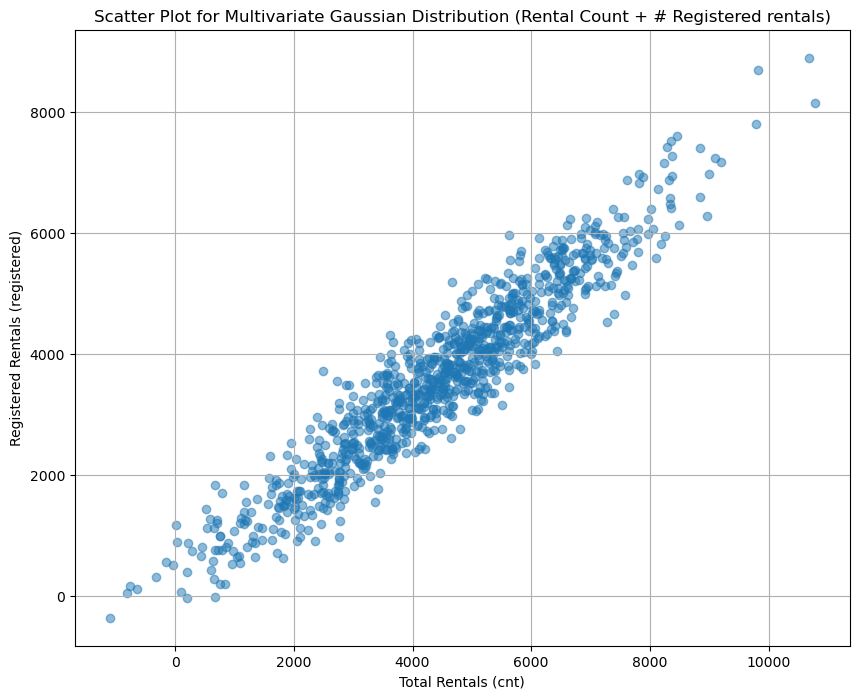

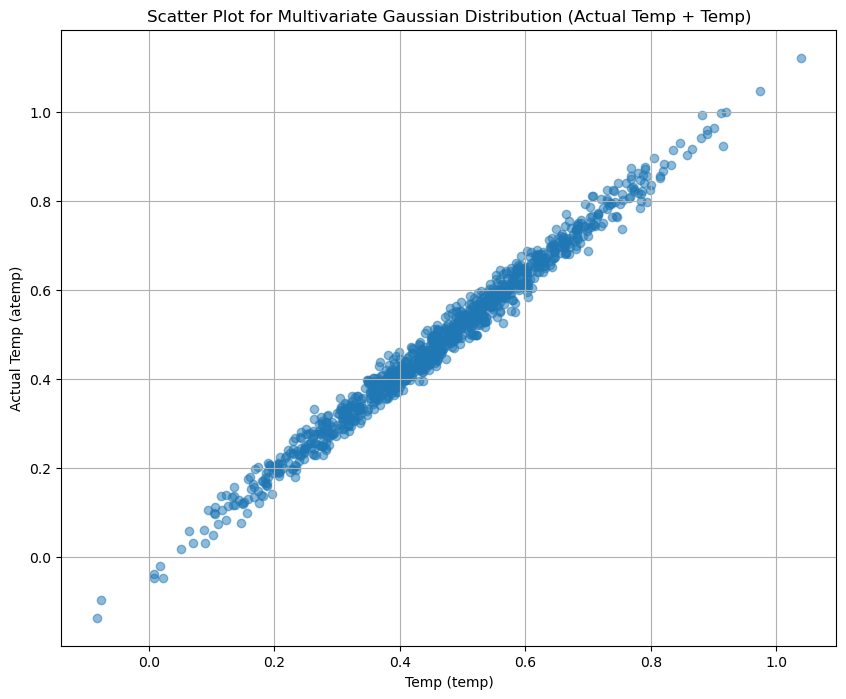

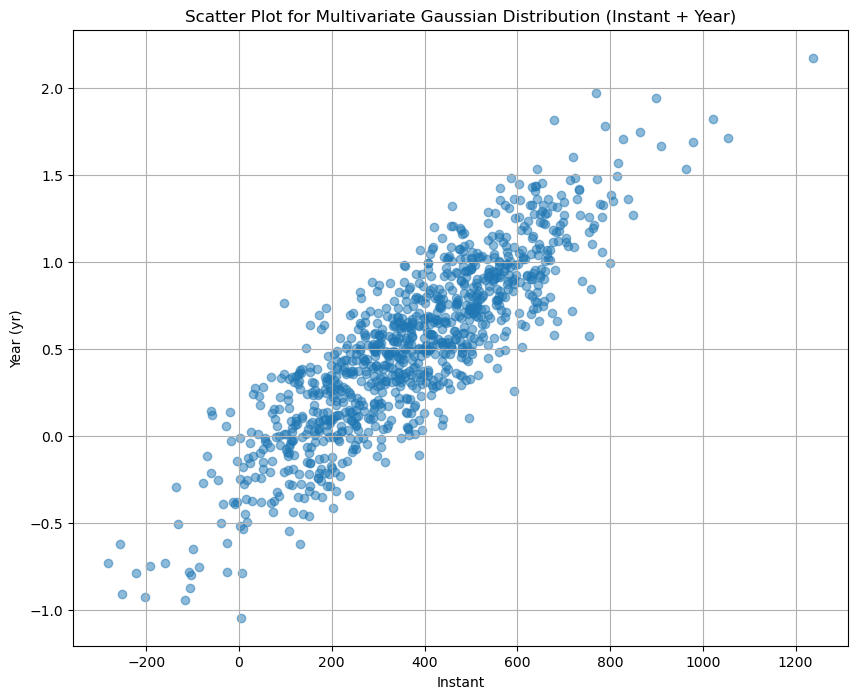

In [71]:
# gaussian for bike_day_df


# get mean and covariance for 'cnt' and 'registered' 
mean_vector = bike_day_df[['cnt', 'registered']].mean().values
covariance_matrix = bike_day_df[['cnt', 'registered']].cov().values

mv_gaussian = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

num_samples = 1000

# Generate random samples from the multivariate Gaussian distribution
samples = mv_gaussian.rvs(size=num_samples)

# plot scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Scatter Plot for Multivariate Gaussian Distribution (Rental Count + # Registered rentals)')
plt.xlabel('Total Rentals (cnt)')
plt.ylabel('Registered Rentals (registered)')
plt.grid(True)
plt.show()

# atemp + temp

# get mean and covariance for 'atemp' and 'temp' 
mean_vector = bike_day_df[['atemp', 'temp']].mean().values
covariance_matrix = bike_day_df[['atemp', 'temp']].cov().values

mv_gaussian = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

num_samples = 1000

# Generate random samples from the multivariate Gaussian distribution
samples = mv_gaussian.rvs(size=num_samples)

# plot scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Scatter Plot for Multivariate Gaussian Distribution (Actual Temp + Temp)')
plt.xlabel('Temp (temp)')
plt.ylabel('Actual Temp (atemp)')
plt.grid(True)
plt.show()


# instant + yr

# get mean and covariance for 'instant' and 'yr' 
mean_vector = bike_day_df[['instant', 'yr']].mean().values
covariance_matrix = bike_day_df[['instant', 'yr']].cov().values

mv_gaussian = multivariate_normal(mean=mean_vector, cov=covariance_matrix)

num_samples = 1000

# Generate random samples from the multivariate Gaussian distribution
samples = mv_gaussian.rvs(size=num_samples)

# plot scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title('Scatter Plot for Multivariate Gaussian Distribution (Instant + Year)')
plt.xlabel('Instant')
plt.ylabel('Year (yr)')
plt.grid(True)
plt.show()

In [73]:
#ORIGINAL NN REGRESSOR

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# Check unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# Add one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# Add one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')


# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]

# list to hold accuracy values
accuracies = []

# list to hold RMSE values
rmse_vals = []

# list to hold each month's predictions (for plotting)
monthly_predictions = []

for month in months_in_2012:
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable
    X_train = train_data.drop(['cnt', 'registered', 'casual'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual'], axis=1)
    y_test = test_data['cnt']

    # Print the columns of X_train
    print(X_train.columns)


    # Drop 'dteday' column from both training and testing data
    X_train = X_train.drop('dteday', axis=1)
    X_test = X_test.drop('dteday', axis=1)

    #Instantiate the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', max_iter=100)

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print the evaluation metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    X_trainVals= set(X_train.index.values) 
    X_testVals= set(X_test.index.values)
    print(X_trainVals.intersection(X_testVals))

    # Make predictions on the testing data
    # y_pred = model.predict(X_test)

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)
    
    # Append the month's predictions to monthly prediction list (for plotting)
    monthly_predictions.append(predictions_df)
    
  # Concatenate the current test data to the training data
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy metrics
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")


[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Index(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'fall', 'spring',
       'summer', 'winter', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')
Mean Squared Error (MSE): 4530140.134589558
Root Mean Squared Error (RMSE): 2128.4125856115297
set()
Predictions for Month: 1
     Actual    Predicted
365    2294  1122.363812
366    1951  1126.115572
367    2236  1129.600664
368    2368  1134.501169
369    3272  1135.221053
370    4098  1138.790618
371    4521  1139.826364
372    3425  1142.838334
373    2376  1149.976739
374    3598  1151.651571
375    2177  1157.253455
376    4097  1160.438920
377    3214  1159.924562
378    2493  1159.753620
379    2311  1163.098386
380    2298  1168.057661
381    2935  1176.395675
382    3376  1175.400058
383    3292  1177.189268
384    3163  1183.142471
385    1301  1

/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (MSE): 6290716.883108768
Root Mean Squared Error (RMSE): 2508.130156732056
set()
Predictions for Month: 3
     Actual    Predicted
425    4990  3011.207854
426    3194  3024.002039
427    4066  3024.160131
428    3423  3022.405303
429    3333  3034.776887
430    3956  3042.451810
431    4916  3052.025261
432    5382  3061.111596
433    4569  3072.890213
434    4118  3061.623445
435    4911  3071.177847
436    5298  3086.030398
437    5847  3096.389629
438    6312  3101.285322
439    6192  3107.992552
440    4378  3122.790224
441    7836  3122.728716
442    5892  3130.163691
443    6153  3136.781305
444    6093  3145.209490
445    6230  3157.534861
446    6871  3156.861244
447    8362  3171.361511
448    3372  3171.268690
449    4996  3178.137730
450    5558  3182.378718
451    5102  3186.066020
452    5698  3196.608711
453    6133  3202.868452
454    5459  3215.872445
455    6235  3217.835199
Index(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'workingday',
       '

/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (MSE): 10781102.18332208
Root Mean Squared Error (RMSE): 3283.458874924746
set()
Predictions for Month: 6
     Actual    Predicted
517    4127  3531.794741
518    8120  3522.787244
519    7641  3527.919550
520    6998  3542.374153
521    7001  3556.794686
522    7055  3554.976802
523    7494  3561.988810
524    7736  3568.748266
525    7498  3569.461742
526    6598  3575.522812
527    6664  3597.300675
528    4972  3605.655831
529    7421  3603.930660
530    7363  3609.641218
531    7665  3615.865417
532    7702  3615.648026
533    6978  3621.051956
534    5099  3643.084525
535    6825  3644.109722
536    6211  3650.310852
537    5905  3656.883086
538    5823  3663.806931
539    7458  3663.280803
540    6891  3668.250134
541    6779  3682.973271
542    7442  3689.214263
543    7335  3695.381660
544    6879  3701.942493
545    5463  3710.295112
546    5687  3710.380930
Index(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'workingday',
       'weathersit', 'temp', 'ate

/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (MSE): 2997163.63733697
Root Mean Squared Error (RMSE): 1731.231826572331
set()
Predictions for Month: 9
     Actual    Predicted
609    6140  5703.206831
610    5810  5712.965588
611    6034  5717.123598
612    6864  5730.718394
613    7112  5738.961105
614    6203  5758.639254
615    7504  5757.468749
616    5976  5768.270040
617    8227  5763.856263
618    7525  5780.480235
619    7767  5788.293724
620    7870  5798.043569
621    7804  5808.509081
622    8009  5818.710093
623    8714  5817.882434
624    7333  5826.144293
625    6869  5855.453840
626    4073  5868.350980
627    7591  5861.341219
628    7720  5871.278940
629    8167  5882.258222
630    8395  5883.849596
631    7907  5889.046145
632    7436  5905.423991
633    7538  5916.956804
634    7733  5927.337345
635    7393  5947.421283
636    7415  5956.566439
637    8555  5944.282792
638    6889  5953.031333
Index(['instant', 'dteday', 'yr', 'mnth', 'holiday', 'workingday',
       'weathersit', 'temp', 'atem

/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


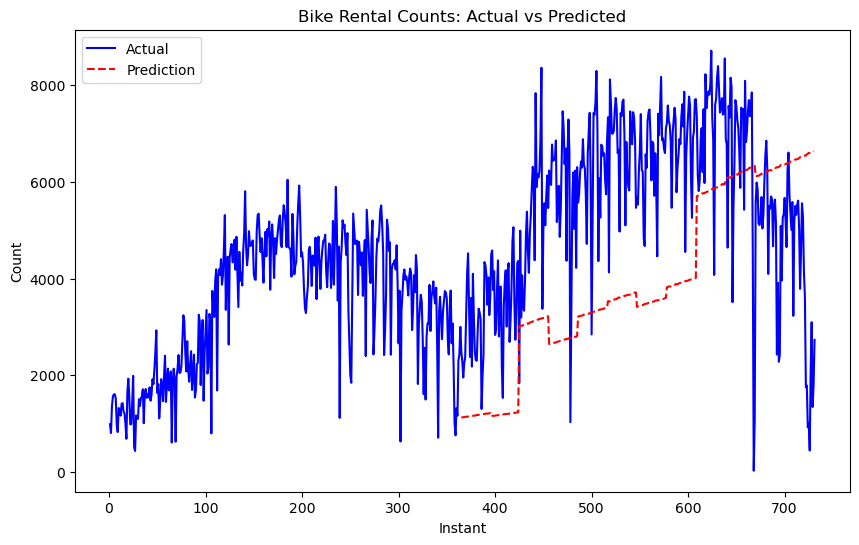

In [74]:
# Plot predicted count (original regressor) vs. actual

bike_day_df_orig = pd.read_csv('bike+sharing+dataset/day.csv')


# Concatenate monthly predictions into prediction df
all_predictions_df = pd.concat(monthly_predictions)

# Now, plot the actual counts and the predicted counts
plt.figure(figsize=(10, 6))

# Plot the actual data
plt.plot(bike_day_df_orig['instant'], bike_day_df_orig['cnt'], label='Actual', color='blue')

# Plot the predicted data
plt.plot(all_predictions_df.index, all_predictions_df['Predicted'], label='Prediction', linestyle='--', color='red')

plt.xlabel('Instant')
plt.ylabel('Count')
plt.title('Bike Rental Counts: Actual vs Predicted')
plt.legend()
plt.show()

In [45]:
# LAGGED VALUES

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

n_lags = 30

# Create lagged features for the cnt column
for lag in range(1, n_lags + 1):
    bike_day_df[f'cnt_lag_{lag}'] = bike_day_df['cnt'].shift(lag)

# Fill any NaN values that result from the lag operation
bike_day_df.fillna(method='bfill', inplace=True)

# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# Check unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# Add one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# Add one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')



# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]
accuracies = []
rmse_vals = []


for month in range(1, 13):  # Loop through months 1 to 12
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable for training and testing
    X_train = train_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_test = test_data['cnt']

    # Instantiate and train the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print evaluation metrics
    print(f"Month: {month}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)

    # Concatenate the current test data to the training data for next iteration
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")

[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Month: 1
Mean Squared Error (MSE): 776522.9229044563
Root Mean Squared Error (RMSE): 881.205380660182
R-squared: -0.0532060954501723
Predictions for Month: 1
     Actual    Predicted
365    2294  2456.800430
366    1951  1943.743760
367    2236  2521.735714
368    2368  1885.395703
369    3272  1892.043575
370    4098  2698.542615
371    4521  3142.591145
372    3425  3281.439884
373    2376  2979.941421
374    3598  2554.847936
375    2177  2443.606400
376    4097  2092.230053
377    3214  3122.667123
378    2493  2772.316134
379    2311  3010.299675
380    2298  3018.078342
381    2935  2482.347981
382    3376  2969.183086
383    3292  2607.369362
384    3163  2823.430772
385    1301  3140.334394
386    1977  2848.337250
387    2432  2963.054117
388    4339  3005.376778
389    4270  3727.392533
390    4075  3409.200597
391    3456  3531.638729
392    4023  2645.812587
393    3243  2960.738682
394    3624  2926.186901
395    4509  3536.02822

Month: 10
Mean Squared Error (MSE): 3239557.053972197
Root Mean Squared Error (RMSE): 1799.8769552311617
R-squared: 0.11221377741737948
Predictions for Month: 10
     Actual    Predicted
639    6778  7560.875221
640    4639  7408.312869
641    7572  6657.581294
642    7328  7464.969625
643    8156  7962.385964
644    7965  8315.155260
645    3510  8065.692899
646    5478  6064.138734
647    6392  6584.199583
648    7691  7582.754324
649    7570  8069.048846
650    7282  7673.967312
651    7109  7121.986014
652    6639  7139.361343
653    5875  6661.408725
654    7534  6845.717311
655    7461  7001.988127
656    7509  7775.107267
657    5424  7407.550363
658    8090  6913.153590
659    6824  7740.584186
660    7058  7007.417511
661    7466  7151.580989
662    7693  7423.582183
663    7359  7994.324863
664    7444  7695.133803
665    7852  7540.981796
666    4459  7432.662528
667      22  6294.608525
668    1096  4639.231904
669    5566  5003.836520
Month: 11
Mean Squared Error (MSE): 12

In [46]:
# Print lagged columns
lagged_columns = [column for column in bike_day_df.columns if 'cnt_lag_' in column]
lagged_df = bike_day_df[lagged_columns]

lagged_df

,cnt_lag_1,cnt_lag_2,cnt_lag_3,cnt_lag_4,cnt_lag_5,cnt_lag_6,cnt_lag_7,cnt_lag_8,cnt_lag_9,cnt_lag_10,...,cnt_lag_21,cnt_lag_22,cnt_lag_23,cnt_lag_24,cnt_lag_25,cnt_lag_26,cnt_lag_27,cnt_lag_28,cnt_lag_29,cnt_lag_30
0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,...,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
1,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,...,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
2,801.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,...,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
3,1349.0,801.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,...,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
4,1562.0,1349.0,801.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,...,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0,985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,441.0,1013.0,920.0,1787.0,1749.0,3623.0,4128.0,5267.0,5557.0,4585.0,...,5375.0,5729.0,6606.0,6234.0,4649.0,5191.0,5668.0,5323.0,5260.0,3959.0
727,2114.0,441.0,1013.0,920.0,1787.0,1749.0,3623.0,4128.0,5267.0,5557.0,...,5008.0,5375.0,5729.0,6606.0,6234.0,4649.0,5191.0,5668.0,5323.0,5260.0
728,3095.0,2114.0,441.0,1013.0,920.0,1787.0,1749.0,3623.0,4128.0,5267.0,...,5582.0,5008.0,5375.0,5729.0,6606.0,6234.0,4649.0,5191.0,5668.0,5323.0
729,1341.0,3095.0,2114.0,441.0,1013.0,920.0,1787.0,1749.0,3623.0,4128.0,...,3228.0,5582.0,5008.0,5375.0,5729.0,6606.0,6234.0,4649.0,5191.0,5668.0


In [57]:
# MOVING AVERAGE

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

def calculate_moving_average(data, window_size=7):
    return data['cnt'].rolling(window=window_size).mean()

# Calculate moving average and add it as a new feature
bike_day_df['cnt_moving_avg'] = calculate_moving_average(bike_day_df)

# Handle NaN values that arise from moving average calculation
bike_day_df['cnt_moving_avg'] = bike_day_df['cnt_moving_avg'].fillna(method='bfill')

# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# Check unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# Add one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# Add one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')


#### add loop here to go thropugh each month of 2012 and add k-1 test data to train data
# Filter data for training (all data from year 1)# Filter data for testing (January of year 2)


# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]
accuracies = []
rmse_vals = []


for month in range(1, 13):  # Loop through months 1 to 12
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable for training and testing
    X_train = train_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_test = test_data['cnt']

    # Instantiate and train the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print evaluation metrics
    print(f"Month: {month}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)

    # Concatenate the current test data to the training data for next iteration
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")

[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]


/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Month: 1
Mean Squared Error (MSE): 598940.2424462098
Root Mean Squared Error (RMSE): 773.9122963528941
R-squared: 0.18765113617596696
Predictions for Month: 1
     Actual    Predicted
365    2294  2071.683549
366    1951  2150.903446
367    2236  2306.456910
368    2368  2303.377123
369    3272  2426.357266
370    4098  2585.793857
371    4521  2874.160709
372    3425  3039.409262
373    2376  3098.030527
374    3598  3305.484248
375    2177  3252.281763
376    4097  3377.303606
377    3214  3267.840658
378    2493  2963.493320
379    2311  2801.116880
380    2298  2780.363402
381    2935  2689.898501
382    3376  2859.489744
383    3292  2745.827135
384    3163  2740.384666
385    1301  2567.987135
386    1977  2522.822517
387    2432  2545.549169
388    4339  2748.267299
389    4270  2864.129983
390    4075  2973.415965
391    3456  3026.087319
392    4023  3423.836278
393    3243  3609.667800
394    3624  3790.394453
395    4509  3815.053191


/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Month: 2
Mean Squared Error (MSE): 644629.2544861326
Root Mean Squared Error (RMSE): 802.8880709576725
R-squared: 0.11938047923800543
Predictions for Month: 2
     Actual    Predicted
396    4579  3943.674605
397    3761  3898.068141
398    4151  4006.090145
399    2832  3824.010335
400    2947  3780.746673
401    3784  3813.573773
402    4375  3796.611753
403    2802  3528.104228
404    3830  3546.840908
405    3831  3501.182627
406    2169  3394.395071
407    1529  3198.380991
408    3422  3152.936443
409    3922  3085.360662
410    4169  3277.606956
411    3005  3158.935419
412    4154  3213.786666
413    4318  3516.089759
414    2689  3676.975040
415    3129  3633.868769
416    3777  3625.328482
417    4773  3704.092213
418    5062  4003.971226
419    3487  3907.488622
420    2732  3677.607529
421    3389  3777.585834
422    4322  3954.192640
423    4363  4040.256633
424    1834  3605.010357
Month: 3
Mean Squared Error (MSE): 819712.2084193915
Root Mean Squared Error (RMSE): 905.37

/Users/ivorteagle/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Month: 7
Mean Squared Error (MSE): 687702.7123783283
Root Mean Squared Error (RMSE): 829.2784287429213
R-squared: 0.055028026789482265
Predictions for Month: 7
     Actual    Predicted
547    5531  6467.273123
548    6227  6390.982308
549    6660  6292.320795
550    7403  6272.280334
551    6241  6213.234688
552    6207  6320.838084
553    4840  6191.873404
554    4672  6055.927703
555    6569  6096.464420
556    6290  6057.177193
557    7264  6035.260361
558    7446  6223.247125
559    7499  6400.130273
560    6969  6697.030953
561    6031  6890.074926
562    6830  6931.190995
563    6786  7017.260506
564    5713  6782.008636
565    6591  6673.111631
566    5870  6427.560383
567    4459  6049.150372
568    7410  6246.599431
569    6966  6279.803970
570    7592  6409.073392
571    8173  6751.389671
572    6861  6803.832369
573    6904  6953.486898
574    6685  7265.418064
575    6597  7136.149707
576    7105  7159.185312
577    7216  7118.337742
Month: 8
Mean Squared Error (MSE): 56187

In [56]:
# MOVING AVERAGE + LAGGED VARIABLES
# NN(hidden_layer_sizes=(64,))

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

n_lags = 30

# Create lagged features for the cnt column
for lag in range(1, n_lags + 1):
    bike_day_df[f'cnt_lag_{lag}'] = bike_day_df['cnt'].shift(lag)

# Fill NaN values that result from the lag operation
bike_day_df.fillna(method='bfill', inplace=True)


# Define function to calculate moving average
def calculate_moving_average(data, window_size=7):
    return data['cnt'].rolling(window=window_size).mean()

# Calculate moving average and add it as a new feature
bike_day_df['cnt_moving_avg'] = calculate_moving_average(bike_day_df)

# Handle NaN values that result from moving average calculation
bike_day_df['cnt_moving_avg'] = bike_day_df['cnt_moving_avg'].fillna(method='bfill')


# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')


# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]

# list to hold accuracy values
accuracies = []

# list to hold RMSE values
rmse_vals = []

# list to hold each month's predictions (for plotting)
monthly_predictions = []


for month in range(1, 13):  # Loop through months 1 to 12
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable for training and testing
    X_train = train_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_test = test_data['cnt']

    # Instantiate and train the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64,), activation='relu', max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print evaluation metrics
    print(f"Month: {month}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)
    
    # Append the month's predictions to monthly prediction list (for plotting)
    monthly_predictions.append(predictions_df)

    # Concatenate the current test data to the training data for next iteration
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy metrics
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")

[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Month: 1
Mean Squared Error (MSE): 627300.6738006496
Root Mean Squared Error (RMSE): 792.0231523135227
R-squared: 0.14918558893832634
Predictions for Month: 1
     Actual    Predicted
365    2294  2218.937500
366    1951  1920.190681
367    2236  2695.600980
368    2368  2317.453729
369    3272  2055.742826
370    4098  2609.728856
371    4521  3350.465416
372    3425  3131.865758
373    2376  2936.789211
374    3598  2717.847249
375    2177  2804.011807
376    4097  2507.735116
377    3214  3133.408016
378    2493  2732.459275
379    2311  2517.081812
380    2298  2906.595587
381    2935  2553.175771
382    3376  3225.499308
383    3292  2331.440175
384    3163  2553.075485
385    1301  2516.288197
386    1977  2583.855181
387    2432  1952.447647
388    4339  2798.970103
389    4270  3665.383025
390    4075  3628.732483
391    3456  2930.566867
392    4023  2707.194663
393    3243  3018.966419
394    3624  3264.024714
395    4509  3545.1608

Month: 10
Mean Squared Error (MSE): 2414157.6557116406
Root Mean Squared Error (RMSE): 1553.755983322877
R-squared: 0.33841081660988515
Predictions for Month: 10
     Actual    Predicted
639    6778  7208.765881
640    4639  7095.699218
641    7572  6337.653697
642    7328  7351.120262
643    8156  7498.105145
644    7965  7804.258665
645    3510  7440.043467
646    5478  5506.172575
647    6392  6687.634245
648    7691  6748.724967
649    7570  7407.839912
650    7282  7574.727528
651    7109  6730.113562
652    6639  6758.170300
653    5875  6302.611992
654    7534  6754.145956
655    7461  6972.007945
656    7509  7549.525102
657    5424  7093.720832
658    8090  6409.286694
659    6824  7337.506200
660    7058  6521.545215
661    7466  7013.496514
662    7693  7269.651876
663    7359  7103.254320
664    7444  7526.563388
665    7852  7155.248383
666    4459  6972.513359
667      22  5201.983711
668    1096  4002.010677
669    5566  5106.081444
Month: 11
Mean Squared Error (MSE): 13

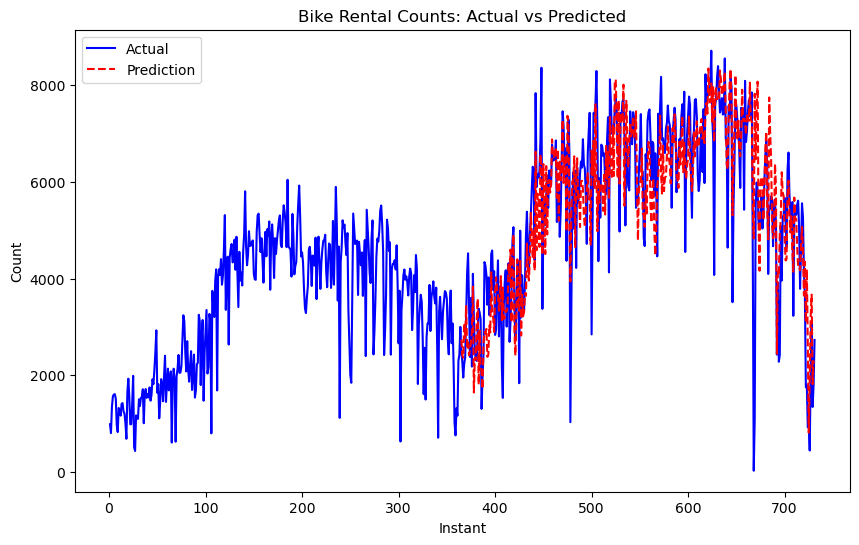

In [55]:
# Plot predicted count (moving avg. + lagged values) vs. actual

bike_day_df_orig = pd.read_csv('bike+sharing+dataset/day.csv')

# Concatenate monthly predictions into prediction df
all_predictions_df = pd.concat(monthly_predictions)

# Plot the actual counts and the predicted counts
plt.figure(figsize=(10, 6))

# Plot the actual data
plt.plot(bike_day_df_orig['instant'], bike_day_df_orig['cnt'], label='Actual', color='blue')

# Plot the predicted data
plt.plot(all_predictions_df.index, all_predictions_df['Predicted'], label='Prediction', linestyle='--', color='red')

plt.xlabel('Instant')
plt.ylabel('Count')
plt.title('Bike Rental Counts: Actual vs Predicted')
plt.legend()
plt.show()

In [54]:
# MOVING AVERAGE + LAGGED VARIABLES, with hyperparamter testing 
# NN(hidden_layer_sizes=(64, 64))

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

n_lags = 30

# Create lagged features for the cnt column
for lag in range(1, n_lags + 1):
    bike_day_df[f'cnt_lag_{lag}'] = bike_day_df['cnt'].shift(lag)

# Fill NaN values that result from the lag operation
bike_day_df.fillna(method='bfill', inplace=True)


# Define function to calculate moving average
def calculate_moving_average(data, window_size=7):
    return data['cnt'].rolling(window=window_size).mean()

# Calculate moving average and add it as a new feature
bike_day_df['cnt_moving_avg'] = calculate_moving_average(bike_day_df)

# Handle NaN values that result from moving average calculation
bike_day_df['cnt_moving_avg'] = bike_day_df['cnt_moving_avg'].fillna(method='bfill')


# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')


# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]

# list to hold accuracy values
accuracies = []

# list to hold RMSE values
rmse_vals = []

# list to hold each month's predictions (for plotting)
monthly_predictions = []


for month in range(1, 13):  # Loop through months 1 to 12
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable for training and testing
    X_train = train_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_test = test_data['cnt']

    # Instantiate and train the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print evaluation metrics
    print(f"Month: {month}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)
    
    # Append the month's predictions to monthly prediction list (for plotting)
    monthly_predictions.append(predictions_df)

    # Concatenate the current test data to the training data for next iteration
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy metrics
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")

[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Month: 1
Mean Squared Error (MSE): 851257.7588964541
Root Mean Squared Error (RMSE): 922.6363091145146
R-squared: -0.1545697287539194
Predictions for Month: 1
     Actual    Predicted
365    2294  2735.742711
366    1951  2412.850823
367    2236  2359.135274
368    2368  3068.294523
369    3272  2765.499892
370    4098  3430.239740
371    4521  2588.702751
372    3425  2677.018383
373    2376  2411.405366
374    3598  2516.258094
375    2177  2685.219225
376    4097  2900.412041
377    3214  3831.998669
378    2493  1640.630311
379    2311  2359.294635
380    2298  2319.442429
381    2935  3161.331302
382    3376  3581.752973
383    3292  1806.513420
384    3163  2922.860652
385    1301  2206.594373
386    1977  2059.377824
387    2432  1718.570381
388    4339  2666.311792
389    4270  2887.287382
390    4075  2854.302410
391    3456  2957.363304
392    4023  2379.838896
393    3243  2424.729717
394    3624  3025.468723
395    4509  2885.2917

Month: 10
Mean Squared Error (MSE): 2798462.8965260475
Root Mean Squared Error (RMSE): 1672.8606925043243
R-squared: 0.23309367220491595
Predictions for Month: 10
     Actual    Predicted
639    6778  7422.181763
640    4639  6360.121501
641    7572  6258.393851
642    7328  7341.816668
643    8156  8029.957490
644    7965  8336.871004
645    3510  7587.673142
646    5478  5306.617042
647    6392  6358.569946
648    7691  7162.503954
649    7570  8207.923823
650    7282  7255.359626
651    7109  6899.246751
652    6639  7267.737979
653    5875  6673.152472
654    7534  6528.565143
655    7461  6969.839116
656    7509  7906.105462
657    5424  7267.541849
658    8090  7302.364160
659    6824  7212.312031
660    7058  6971.741197
661    7466  7420.144770
662    7693  7307.743689
663    7359  7261.577073
664    7444  8052.122342
665    7852  7286.262635
666    4459  7243.681006
667      22  5487.394190
668    1096  4826.964076
669    5566  7822.530192
Month: 11
Mean Squared Error (MSE): 1

In [51]:
# MOVING AVERAGE + LAGGED VARIABLES, with hyperparamter testing 
# NN(hidden_layer_sizes=(64, 64), early_stopping=True)

bike_day_df = pd.read_csv('bike+sharing+dataset/day.csv')

# Define number of lags
n_lags = 30

# Create lagged features for the cnt column
for lag in range(1, n_lags + 1):
    bike_day_df[f'cnt_lag_{lag}'] = bike_day_df['cnt'].shift(lag)

# Fill NaN values that result from the lag operation
bike_day_df.fillna(method='bfill', inplace=True)


# Define function to calculate moving average
def calculate_moving_average(data, window_size=7):
    return data['cnt'].rolling(window=window_size).mean()

# Calculate moving average and add it as a new feature
bike_day_df['cnt_moving_avg'] = calculate_moving_average(bike_day_df)

# Handle NaN values that result from moving average calculation
bike_day_df['cnt_moving_avg'] = bike_day_df['cnt_moving_avg'].fillna(method='bfill')


# Check unique values in the 'yr' column
print(bike_day_df['yr'].unique())

# unique values in the 'mnth' column
print(bike_day_df['mnth'].unique())

bike_day_df['dteday'] = pd.to_datetime(bike_day_df['dteday'])

# one-hot encoding for the 'season' column
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
bike_day_df['season'] = bike_day_df['season'].map(season_mapping)
bike_day_df = pd.get_dummies(bike_day_df, columns=['season'], prefix='', prefix_sep='')

# one-hot encoding for the 'weekday' column
bike_day_df = pd.get_dummies(bike_day_df, columns=['weekday'], prefix='weekday', prefix_sep='_')


# Number of months in 2012
months_in_2012 = bike_day_df[bike_day_df['yr'] == 1]['mnth'].unique()

# Iterate through each month (including January)
train_data = bike_day_df[bike_day_df['yr'] == 0]

# list to hold accuracy values
accuracies = []

# list to hold RMSE values
rmse_vals = []

# list to hold each month's predictions (for plotting)
monthly_predictions = []


for month in range(1, 13):  # Loop through months 1 to 12
    # Filter data for testing (specific month of year 2)
    test_data = bike_day_df[(bike_day_df['yr'] == 1) & (bike_day_df['mnth'] == month)]

    # Separate features and target variable for training and testing
    X_train = train_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_train = train_data['cnt']
    X_test = test_data.drop(['cnt', 'registered', 'casual', 'dteday'], axis=1)
    y_test = test_data['cnt']

    # Instantiate and train the MLPRegressor model
    model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=1000, early_stopping=True)
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store the accuracy
    accuracies.append(r2)
    rmse_vals.append(rmse)

    # Print evaluation metrics
    print(f"Month: {month}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared: {r2}")

    # Create and print a DataFrame to display the actual and predicted 'cnt' values
    predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    print("Predictions for Month:", month)
    print(predictions_df)
    
    # Append the month's predictions to monthly prediction list (for plotting)
    monthly_predictions.append(predictions_df)

    # Concatenate the current test data to the training data for next iteration
    train_data = pd.concat([train_data, test_data])

# Calculate and print the average accuracy metrics
average_accuracy = np.mean(accuracies)
average_rmse = np.mean(rmse_vals)
print(f"Average R-squared for all months: {average_accuracy}")
print(f"Average RMSE for all months: {average_rmse}")

[0 1]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Month: 1
Mean Squared Error (MSE): 1078639.9658833535
Root Mean Squared Error (RMSE): 1038.5759316888455
R-squared: -0.4629705747969164
Predictions for Month: 1
     Actual    Predicted
365    2294  2914.244816
366    1951  2606.577668
367    2236  2302.657430
368    2368  2693.061684
369    3272  2026.611035
370    4098  2135.269435
371    4521  2321.722620
372    3425  2323.726946
373    2376  1874.641036
374    3598  1940.290743
375    2177  1933.122373
376    4097  2019.379575
377    3214  2054.856513
378    2493  2309.435781
379    2311  2532.741895
380    2298  2394.412746
381    2935  3258.110554
382    3376  3182.606191
383    3292  3213.618684
384    3163  2915.640884
385    1301  2662.703105
386    1977  2991.503113
387    2432  2753.138245
388    4339  3495.471876
389    4270  3085.374279
390    4075  3211.992511
391    3456  2910.325655
392    4023  2613.393524
393    3243  3019.173036
394    3624  2671.898962
395    4509  2790.72

Month: 12
Mean Squared Error (MSE): 1943039.7658162133
Root Mean Squared Error (RMSE): 1393.929612934675
R-squared: 0.3825228250073348
Predictions for Month: 12
     Actual    Predicted
700    5191  4846.003461
701    4649  5171.024383
702    6234  4616.685997
703    6606  5666.370024
704    5729  6050.718135
705    5375  5728.722516
706    5008  5301.437334
707    5582  5220.843479
708    3228  5111.175596
709    5170  4363.224040
710    5501  4753.081525
711    5319  4759.902794
712    5532  5100.338587
713    5611  5156.794815
714    5047  5054.522071
715    3786  5319.838471
716    4585  4914.879222
717    5557  5368.084366
718    5267  5656.097545
719    4128  5457.126137
720    3623  5141.323499
721    1749  4638.326586
722    1787  3834.965720
723     920  3866.021390
724    1013  4033.585577
725     441  3041.550976
726    2114  3180.977315
727    3095  3114.646947
728    1341  3399.212900
729    1796  2899.555699
730    2729  2853.346812
Average R-squared for all months: -0.16